<a href="https://colab.research.google.com/github/cs-iuu/word-sense-2025-fall-ai/blob/main/notebooks/13.2.wsi_cross_lingual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mongolian WSI Notebook

**Word-Sense Induction (WSI) demo for Mongolian**

**Target words:** зам, гэр, амар, сайн, хүн, нэг

This notebook trains a SentencePiece tokenizer (BPE) on your, extracts contexts for selected target words, computes contextual embeddings with a multilingual SentenceTransformer, clusters contexts (HDBSCAN) to discover senses, visualizes the results (UMAP), and exports a JSON with induced sense examples.

---

**Instructions:** Upload your corpus file. Each line should be a verse or sentence. If your file is large, Colab may take time to train the tokenizer; we keep sizes conservative by default.


In [ ]:
# Install required libraries
!pip install -q sentencepiece sentence-transformers hdbscan umap-learn sklearn matplotlib seaborn

# show versions
import sentencepiece, sklearn, sentence_transformers
print("sentencepiece", sentencepiece.__version__)
print("sentence-transformers", sentence_transformers.__version__)
print("sklearn", sklearn.__version__)

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
sentencepiece 0.2.1
sentence-transformers 5.1.2
sklearn 1.6.1


In [ ]:
# # Upload mn_bible.txt
# from google.colab import files
# uploaded = files.upload()
# if len(uploaded) == 0:
#     raise SystemExit("Please upload mn_bible.txt")
# filename = list(uploaded.keys())[0]
# print("Uploaded file:", filename)

file_path = "/content/Tungalag_Tamir.txt"
# Read lines
with open(file_path, "r", encoding="utf-8") as f:
    lines = [l.strip() for l in f if l.strip()]
print(f"Loaded {len(lines)} non-empty lines")

Loaded 15991 non-empty lines


In [ ]:
# Train SentencePiece BPE tokenizer on the corpus (small vocab to keep it fast)
import sentencepiece as spm
corpus_path = file_path
model_prefix = "mn_sp"
vocab_size = 8000

spm.SentencePieceTrainer.train(
    input=corpus_path,
    model_prefix=model_prefix,
    vocab_size=vocab_size,
    model_type="bpe",
    character_coverage=0.9995,
    bos_id=-1, eos_id=-1
)

print("Trained SentencePiece model:", model_prefix + ".model")

Trained SentencePiece model: mn_sp.model


In [ ]:
# Load SentencePiece model and test tokenization
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.load("mn_sp.model")

test_sent = lines[0] if len(lines)>0 else "Би сургуульд явж байна."
print("Example sentence:", test_sent)
print("SP tokens:", sp.encode(test_sent, out_type=str)[:50])

Example sentence: Тунгалаг тамир
SP tokens: ['▁Ту', 'нгалаг', '▁тамир']


In [ ]:
# Define target words and extract context windows
targets = ["зам", "гэр", "амар", "сайн", "хүн", "ам"]  # chosen target words
print("Targets:", targets)

window = 5  # context window size (words either side)
max_examples_per_word = 500  # cap to limit runtime

from collections import defaultdict
contexts = defaultdict(list)   # word -> list of context strings
occurrence_meta = defaultdict(list)  # store (line_id, line_text) pairs

for idx, line in enumerate(lines):
    toks = line.split()
    for i, tok in enumerate(toks):
        if tok in targets:
            start = max(0, i-window)
            end = min(len(toks), i+window+1)
            ctx = " ".join(toks[start:end])
            if len(contexts[tok]) < max_examples_per_word:
                contexts[tok].append(ctx)
                occurrence_meta[tok].append((idx, line))

# Show counts
for t in targets:
    print(f"{t}: {len(contexts[t])} contexts")

Targets: ['зам', 'гэр', 'амар', 'сайн', 'хүн', 'ам']
зам: 54 contexts
гэр: 121 contexts
амар: 16 contexts
сайн: 257 contexts
хүн: 10 contexts
ам: 61 contexts


In [ ]:
# Load multilingual sentence-transformer and encode contexts
from sentence_transformers import SentenceTransformer

# model_name = "paraphrase-multilingual-mpnet-base-v2"
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

print("Loading model:", model_name)
smodel = SentenceTransformer(model_name)

# Prepare encoding
all_contexts = []
for w, ctxs in contexts.items():
    for c in ctxs:
        all_contexts.append(c)

print("Total contexts to encode:", len(all_contexts))
embs = smodel.encode(all_contexts, show_progress_bar=True, convert_to_numpy=True)

Loading model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Total contexts to encode: 519


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
# Cluster contexts per word using HDBSCAN
import numpy as np
import hdbscan

# We'll cluster each word's contexts separately and store labels
start_idx = 0
word_clusters = {}

for w in targets:
    n = len(contexts[w])
    if n == 0:
        word_clusters[w] = {"labels": [], "embeddings": None, "contexts": []}
        continue
    sub_embs = embs[start_idx:start_idx+n]
    start_idx += n

    # use HDBSCAN for unknown k; set min_cluster_size
    clusterer = hdbscan.HDBSCAN(min_cluster_size=max(3, min(10, n//10)), metric='euclidean')
    labels = clusterer.fit_predict(sub_embs)
    word_clusters[w] = {"labels": labels.tolist(), "embeddings": sub_embs.tolist(), "contexts": contexts[w]}
    print(f"{w}: clusters found (unique labels):", set(labels))

зам: clusters found (unique labels): {np.int64(-1)}
гэр: clusters found (unique labels): {np.int64(-1)}
амар: clusters found (unique labels): {np.int64(-1)}
сайн: clusters found (unique labels): {np.int64(-1)}
хүн: clusters found (unique labels): {np.int64(-1)}
ам: clusters found (unique labels): {np.int64(-1)}


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skle

In [ ]:
# Function to show clusters for a given word
import numpy as np
from collections import defaultdict, Counter

def show_clusters(word, topk=5):
    data = word_clusters[word]
    labels = np.array(data['labels'])
    ctxs = data['contexts']
    if len(labels)==0:
        print("No contexts for", word); return
    unique = sorted(set(labels))
    for lbl in unique:
        if lbl == -1:
            print("\n-- Noise / unclustered --")
        else:
            print(f"\n== Sense cluster {lbl} ==")
        idxs = np.where(labels==lbl)[0]
        print(f"Count: {len(idxs)}")
        # show top representative contexts (first few)
        for i in idxs[:topk]:
            print(" -", ctxs[i])
        # show top words in these contexts
        words = []
        for i in idxs:
            words.extend(ctxs[i].split())
        c = Counter(words)
        print("Top context words:", c.most_common(10))

# Example: show clusters for all targets
for t in targets:
    print('\n' + '='*40)
    print('WORD:', t)
    show_clusters(t, topk=5)


WORD: зам

-- Noise / unclustered --
Count: 54
 - эхнэр хүүхдээ дагуулан хүрээний зүг зам хөөжээ.
 - хэд дахин шунаг сороод, ирсэн зам руугаа харлаа. Тэртээ
 - Эгийн давааны цаана байдаг могойн зам гэгч харагдсанаас эхлэн Тайхар чулууны
 - хоёрыг салгаж чадаагvй болохоор өөр зам
 - уулзан арга зай хайхаас өөр зам байсангvй.
Top context words: [('зам', 56), ('нь', 8), ('юм', 5), ('дээр', 5), ('гэж', 4), ('хоёрын', 4), ('ганц', 4), ('бол', 4), ('-', 4), ('болохоор', 3)]

WORD: гэр

-- Noise / unclustered --
Count: 121
 - Долгор гэдэг бүсгүйтэй дэр нийлүүлэн гэр
 - чандмалан буусан гурван гэр хот айл харагдана.
 - хэлээд хойт гэр рvv гvйн очиж өрхийг татаад
 - босвол дээр байхаа гээд зvvн гэр рvv алхтал гэрээс ахимаг насны
 - хэлээд паржигнан инээхэд нь их гэр доргих шиг
Top context words: [('гэр', 125), ('нь', 27), ('рvv', 13), ('ханатай', 11), ('дээр', 9), ('Итгэлтийн', 9), ('гэж', 9), ('бор', 8), ('барьж', 8), ('хэдэн', 7)]

WORD: амар

-- Noise / unclustered --
Count: 16
 - vг яриа н


Plotting: зам


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-1475014946.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(unique))


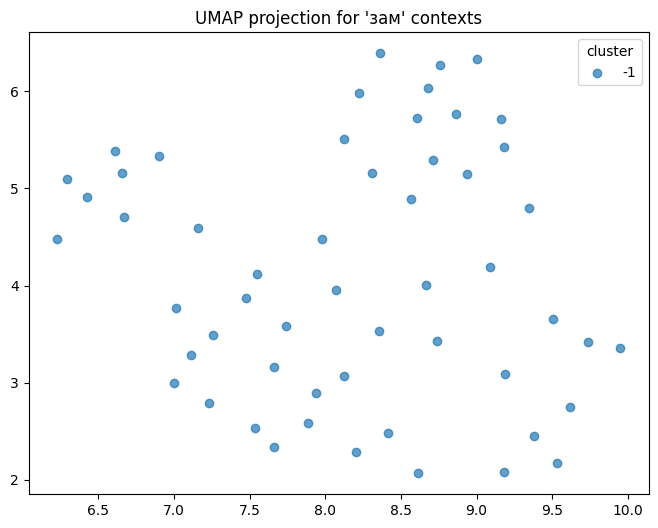


Plotting: гэр


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-1475014946.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(unique))


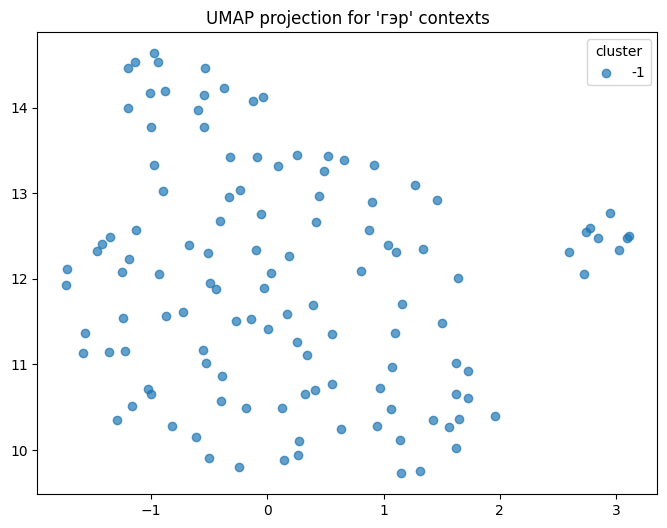

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-1475014946.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(unique))



Plotting: амар


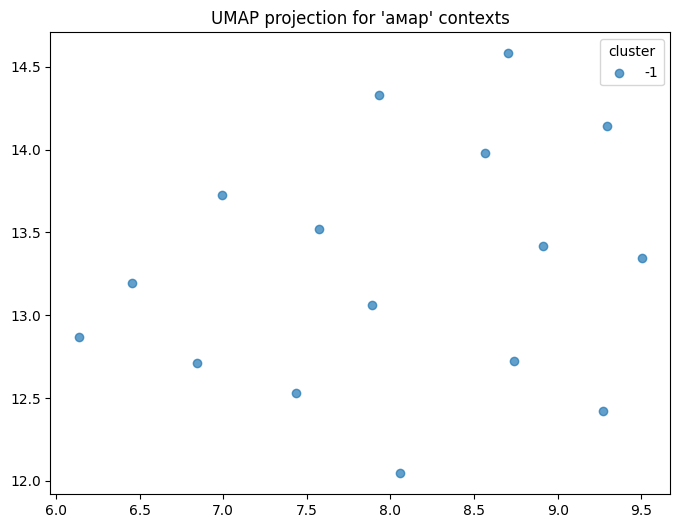


Plotting: сайн


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-1475014946.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(unique))


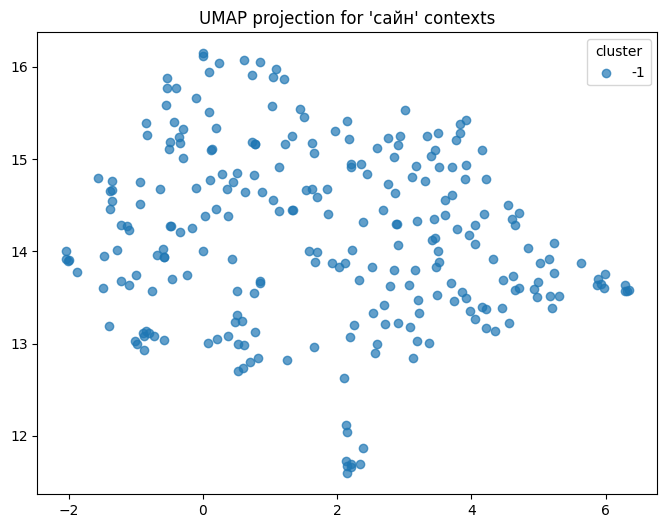

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/tmp/ipython-input-1475014946.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(unique))



Plotting: хүн


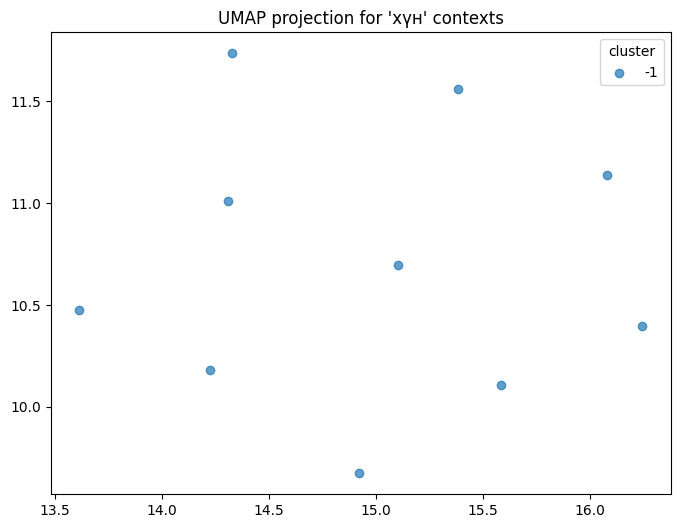


Plotting: ам


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-1475014946.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(unique))


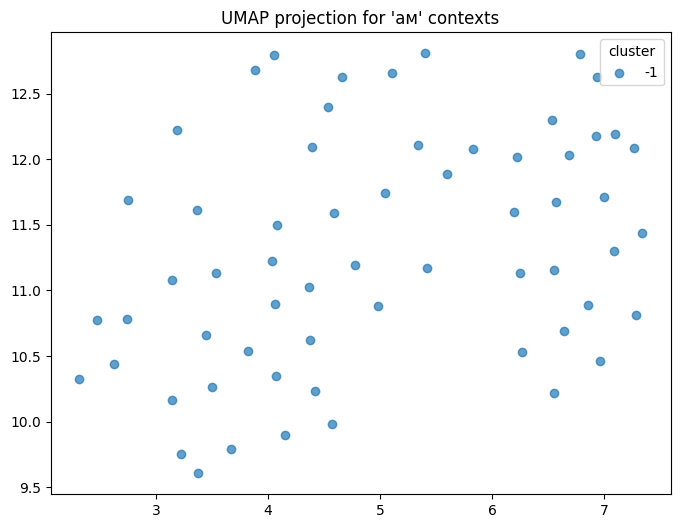

In [ ]:
# Visualize cluster embeddings for a chosen word using UMAP
import umap
import matplotlib.pyplot as plt
import numpy as np

def plot_word_umap(word):
    data = word_clusters[word]
    labels = np.array(data['labels'])
    em = np.array(data['embeddings'])
    if em.size == 0:
        print("No data")
        return
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42)
    red = reducer.fit_transform(em)
    plt.figure(figsize=(8,6))
    unique = sorted(set(labels))
    palette = plt.cm.get_cmap('tab10', len(unique))
    for i, lbl in enumerate(unique):
        mask = (labels==lbl)
        plt.scatter(red[mask,0], red[mask,1], label=str(lbl), alpha=0.7)
    plt.legend(title='cluster')
    plt.title(f"UMAP projection for '{word}' contexts")
    plt.show()

# Plot for each target (first few)
for t in targets:
    try:
        print("\nPlotting:", t)
        plot_word_umap(t)
    except Exception as e:
        print("Plot error for", t, e)

In [ ]:
# Save induced senses to JSON for inspection or later use
import json
out = {}
for w in targets:
    data = word_clusters[w]
    labels = data['labels']
    ctxs = data['contexts']
    clusters = {}
    for lbl in sorted(set(labels)):
        inds = [i for i, lab in enumerate(labels) if lab==lbl]
        clusters[str(lbl)] = {
            "count": len(inds),
            "examples": [ctxs[i] for i in inds[:10]]
        }
    out[w] = clusters

with open("mn_wsi_results.json", "w", encoding="utf-8") as f:
    json.dump(out, f, ensure_ascii=False, indent=2)

print('Saved mn_wsi_results.json')

Saved mn_wsi_results.json


# Cross-Lingual

## Setup

In [ ]:
# Install necessary libraries
!pip install transformers torch pandas numpy scikit-learn nltk h5py


In [ ]:
# Download NLTK resources
import nltk
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('tokenizers/punkt_tab')
    nltk.data.find('taggers/averaged_perceptron_tagger')
    nltk.data.find('taggers/averaged_perceptron_tagger_eng')
    nltk.data.find('corpora/stopwords') # Check for stopwords as well
except LookupError:
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('averaged_perceptron_tagger_eng')
    nltk.download('stopwords') # Download stopwords if not found

import os
import time
import pandas as pd
import numpy as np
import torch
import h5py
import re
from collections import Counter
from transformers import BertTokenizer, BertModel # Use mBERT for multilingual
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cosine

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# --- Configuration ---
HDF5_EMBEDDINGS_FILE = 'corpus_embeddings.h5'
INDEX_FILE = 'corpus_index.pkl'
BATCH_SIZE = 32

# Content word filtering constants
STOP_WORDS = set(nltk.corpus.stopwords.words('english')) # Add Mongolian stopwords if analyzing MN
CONTENT_TAGS_PREFIX = ('NN', 'VB', 'JJ', 'RB') # Noun, Verb, Adjective, Adverb

# 1. Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# 2. Model Loading (mBERT for Multilingual Analysis)
MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)
model.to(device)
model.eval()
GLOBAL_VECTOR_DIM = model.config.hidden_size # Should be 768

# --- Global Data Structures ---
index_data = [] # List to accumulate index records

# 3. Clustering Helper Function
def find_optimal_k_and_cluster(X, max_k=5):
    """Finds optimal K using Silhouette Score and performs final clustering."""
    if len(X) < 2: return 1, np.zeros(len(X))
    if len(X) <= max_k: max_k = len(X) - 1

    scores = {}
    best_k = 1
    best_score = -1
    best_labels = None

    # We only test K >= 2 for silhouette
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        scores[k] = score

        if score > best_score:
            best_score = score
            best_k = k
            best_labels = labels

    if best_labels is None: # Fallback if no score could be computed (e.g., all instances identical)
        best_k = 1
        return best_k, np.zeros(len(X))

    return best_k, best_labels

# 4. Sense Prototype Helper Function (Centroid Proximity)
def generate_sense_prototypes(sense_clusters, X_vectors, labels, model_vocab, target_word_lower, top_n=5):
    """Calculates the centroid for each induced sense cluster and finds the closest global vocabulary words."""
    interpretation = {}
    n_clusters = len(sense_clusters)

    for sense_id in range(n_clusters):
        cluster_vectors = X_vectors[labels == sense_id]
        if len(cluster_vectors) == 0: continue

        centroid = np.mean(cluster_vectors, axis=0)
        similarity_scores = {}

        for word, word_vector in model_vocab.items():
            if word == target_word_lower: continue # Skip the target word itself

            # Ensure vector dimensions match before calculation
            if word_vector.shape[0] != GLOBAL_VECTOR_DIM: continue

            similarity = 1 - cosine(centroid, word_vector)
            similarity_scores[word] = similarity

        sorted_prototypes = sorted(similarity_scores.items(), key=lambda item: item[1], reverse=True)
        top_prototypes = [word for word, score in sorted_prototypes[:top_n]]
        interpretation[sense_id] = top_prototypes

    return interpretation

# 5. Global Vocabulary Placeholder (Must be replaced with actual MN/EN word vectors)
# For the Centroid Proximity method, you MUST ensure these vectors are 768-dim.
GLOBAL_VOCAB_VECTORS = {} # Placeholder; will be populated by an actual dataset average or a loaded file
print("⚠️ GLOBAL_VOCAB_VECTORS is a placeholder. Must be populated with 768-dim word vectors for accurate prototyping.")

✅ Using device: cpu
⚠️ GLOBAL_VOCAB_VECTORS is a placeholder. Must be populated with 768-dim word vectors for accurate prototyping.


## Resumable Batched Embedding Function

In [ ]:
# --- Stage 1: Resumable Batched Embedding Function ---

def initialize_resumable_processing(index_file, hdf5_file):
    """Loads existing index and returns the next global sentence ID and the HDF5 file handle."""
    global index_data

    start_global_idx_from_index = 0
    if os.path.exists(index_file):
        index_df = pd.read_pickle(index_file)
        index_data = index_df.to_dict('records') # Update global index_data
        start_global_idx_from_index = index_df['sentence_id'].max() + 1 if not index_df.empty else 0
        print(f"Index loaded from {index_file}. Proposed resume global index: {start_global_idx_from_index}")
    else:
        if os.path.exists(hdf5_file):
            print(f"Index file not found, but HDF5 file {hdf5_file} exists. Deleting HDF5 file for a fresh start.")
            os.remove(hdf5_file)
        index_data = [] # Initialize global index_data for fresh start
        print(f"No index file found ({index_file}). Starting fresh from global index: 0")

    # Open HDF5 file
    h5f = h5py.File(hdf5_file, 'a')
    print(f"HDF5 file opened in append mode ('a') at {hdf5_file}.")

    # Determine the actual starting index by checking existing datasets in HDF5
    start_global_idx_from_h5 = 0
    if h5f.keys():
        existing_sent_ids = []
        for key in h5f.keys():
            if key.startswith('sent_') and key[len('sent_'):].isdigit():
                existing_sent_ids.append(int(key[len('sent_'):]))
        if existing_sent_ids:
            start_global_idx_from_h5 = max(existing_sent_ids) + 1

    # Take the maximum of the two determined starting indices
    # This handles cases where index file is behind HDF5 file, or vice-versa
    start_global_idx = max(start_global_idx_from_index, start_global_idx_from_h5)
    print(f"Actual global index for new sentences will start at: {start_global_idx}")

    return h5f, start_global_idx


def process_corpus_general_batched(corpus, model, tokenizer, batch_size, device, h5f, start_global_idx, content_tags_prefix, stop_words):
    """Processes a new corpus batch, continuing the global indexing from start_global_idx."""

    global index_data
    batched_corpus = [corpus[i:i + batch_size] for i in range(0, len(corpus), batch_size)]
    global_sent_idx = start_global_idx

    print(f"Processing {len(corpus)} new sentences in {len(batched_corpus)} batches.")

    for batch_id, batch_texts in enumerate(batched_corpus):
        print(f"Processing batch {batch_id + 1}/{len(batched_corpus)}")

        # A. BERT Inference
        encoded_input = tokenizer(
            batch_texts,
            return_tensors='pt',
            padding='max_length',
            truncation=True
        ).to(device)

        with torch.no_grad():
            outputs = model(**encoded_input)
            full_hidden_states = outputs[0].cpu().numpy()

        # B. Process each sentence for indexing and saving
        for sent_in_batch, text in enumerate(batch_texts):

            input_ids_tensor = encoded_input['input_ids'][sent_in_batch].cpu()

            # Disk Write: HDF5
            embedding_array = full_hidden_states[sent_in_batch]
            # Only create the dataset if it doesn't already exist
            if f'sent_{global_sent_idx}' not in h5f:
                h5f.create_dataset(f'sent_{global_sent_idx}', data=embedding_array, compression="gzip")
            else:
                # If it exists, it means it was previously written. We should probably just overwrite it
                # or skip it if we assume it's correct. For robustness, I'll overwrite to ensure data integrity
                # in case of incomplete previous writes, but this decision depends on exact resume strategy.
                # For now, let's assume if it exists, it was meant to be there, and we're starting AFTER it.
                # The start_global_idx logic should prevent this block from being hit for the *first* sentence.
                pass

            # NLTK tokenization and POS tagging
            nltk_tokens = nltk.word_tokenize(text)
            tagged_tokens = nltk.pos_tag(nltk_tokens) # Note: POS tags may be less accurate for Mongolian

            content_words = [(word.lower(), tag) for word, tag in tagged_tokens
                             if word.isalpha() and word.lower() not in stop_words and tag.startswith(content_tags_prefix)]

            bert_tokens = tokenizer.convert_ids_to_tokens(input_ids_tensor.tolist())

            # Build the Index
            for word, _ in content_words:
                target_indices = [i for i, token in enumerate(bert_tokens)
                                  if word in token or word.capitalize() in token] # Simple token alignment

                if target_indices:
                    index_data.append({
                        'target_word': word,
                        'sentence_id': global_sent_idx,
                        'token_indices': target_indices,
                        'sentence': text
                    })

            global_sent_idx += 1

## Execution

In [ ]:
file_path = "/content/Tungalag_Tamir.txt"
# Read lines
with open(file_path, "r", encoding="utf-8") as f:
    lines = [l.strip() for l in f if l.strip()]
print(f"Loaded {len(lines)} non-empty lines")


Loaded 15991 non-empty lines


In [ ]:
# --- Placeholder for Mongolian Corpus (Replace with your 929K sentences) ---
# mongolian_corpus = [
#     "Энэ бол санхүүгийн банк юм.", # This is a financial bank.
#     "Тэрээр мөрөнгийн эрэг дээр зогсож байв.", # He was standing on the river bank.
#     "Од гялалзаж байна.", # The star is twinkling.
#     "Тэр бол кино од.", # That is a movie star.
#     "Бидэнд шинэ амьдрал хэрэгтэй.", # We need a new life.
#     "Сүнс минь хүчтэй.", # My spirit is strong.
# ]
mongolian_corpus = lines

# --- IMPORTANT: Configure Mongolian Files ---
MN_HDF5_FILE = 'mn_corpus_embeddings.h5'
MN_INDEX_FILE = 'mn_corpus_index.pkl'

# Initialize and resume processing
mn_h5f, mn_start_index = initialize_resumable_processing(MN_INDEX_FILE, MN_HDF5_FILE)

# Run the embedding generation
process_corpus_general_batched(
    corpus=mongolian_corpus,
    model=model,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    device=device,
    h5f=mn_h5f,
    start_global_idx=mn_start_index,
    content_tags_prefix=CONTENT_TAGS_PREFIX,
    stop_words=STOP_WORDS # Use MN stopwords here if available
)

# Final Save and Cleanup for Mongolian
mn_h5f.close()
mn_index_df = pd.DataFrame(index_data)
mn_index_df.to_pickle(MN_INDEX_FILE)
print(f"✅ Stage 1 complete. Files saved: {MN_HDF5_FILE}, {MN_INDEX_FILE}")

## Analysis

In [ ]:
def get_target_vectors_from_store(target_word, index_df, hdf5_file):
    """
    Retrieves the contextualized BERT vectors for all occurrences of a target word,
    reading the embedding data directly from the specified HDF5 file.
    """

    matches = index_df[index_df['target_word'] == target_word.lower()]

    if matches.empty:
        return None, None # Return None for X and sentences

    target_vectors = []
    sentences = []

    with h5py.File(hdf5_file, 'r') as hf:
        for _, row in matches.iterrows():
            sent_id = row['sentence_id']
            token_indices = row['token_indices']

            try:
                full_sent_embedding = hf[f'sent_{sent_id}'][()]
            except KeyError:
                continue

            # Word vector is the mean of its sub-token embeddings
            word_vector = np.mean(full_sent_embedding[token_indices], axis=0)
            target_vectors.append(word_vector)
            sentences.append(row['sentence'])

    return np.array(target_vectors), sentences

In [ ]:
# --- IMPORTANT: Global Vocabulary Setup ---
# For demonstration, we use random vectors, but in production, these must be
# 768-dim averaged mBERT vectors for Mongolian words.
# We'll re-initialize the dummy vocab to include Mongolian words
MONGOLIAN_WORDS_FOR_VOCAB = ["банк", "од", "сүнс", "мөнгө", "амьдрал", "эрг", "гол"]
for word in MONGOLIAN_WORDS_FOR_VOCAB:
    vec = np.random.rand(GLOBAL_VECTOR_DIM)
    GLOBAL_VOCAB_VECTORS[word] = vec / np.linalg.norm(vec)
print(f"⚠️ Global Vocabulary now contains {len(GLOBAL_VOCAB_VECTORS)} words for prototyping.")

# --- Define Mongolian Words to Analyze ---
MONGOLIAN_WORDS = ["банк", "од"]

print("\n--- Starting Stage 2: Mongolian Sense Induction and Prototyping ---")

# Load the Mongolian Index
mn_index_df = pd.read_pickle(MN_INDEX_FILE)

for word in MONGOLIAN_WORDS:
    run_start = time.time()
    TARGET_WORD_LOWER = word.lower()

    # A. Retrieve vectors quickly using the Mongolian files
    X, sentences = get_target_vectors_from_store(word, mn_index_df, MN_HDF5_FILE)

    if X is None:
        print(f"  Skipping '{word}': Not enough instances found.")
        continue

    # B. Find optimal K and cluster
    optimal_k, labels = find_optimal_k_and_cluster(X, max_k=5)

    # C. Group Results
    sense_clusters = {i: [sentences[j] for j, label in enumerate(labels) if label == i] for i in range(optimal_k)}

    # D. Generate Dictionary-like Meanings using Centroid Proximity
    sense_prototypes = generate_sense_prototypes(
        sense_clusters,
        X,
        labels,
        GLOBAL_VOCAB_VECTORS,
        TARGET_WORD_LOWER,
        top_n=3 # Lower top_n for small dummy vocab
    )

    # E. Display Final Results
    run_end = time.time()
    print(f"\n## 🎯 Induced Senses for Mongolian '{word}' (K={optimal_k}) (Run Time: {run_end - run_start:.4f}s) ##")

    for i in range(optimal_k):
        sentences_in_sense = sense_clusters.get(i, [])
        prototypes = sense_prototypes.get(i, ["(No prototypes found)"])

        print(f"\n--- Sense Cluster {i+1} ({len(sentences_in_sense)} instances) ---")
        print(f"  Sense Prototype: **{', '.join(prototypes)}**")

        if sentences_in_sense:
            print("  Example Sentence:")
            print(f"  - {sentences_in_sense[0]}")

        print("-" * 20)

⚠️ Global Vocabulary now contains 7 words for prototyping.

--- Starting Stage 2: Mongolian Sense Induction and Prototyping ---

## 🎯 Induced Senses for Mongolian 'банк' (K=1) (Run Time: 0.0151s) ##

--- Sense Cluster 1 (1 instances) ---
  Sense Prototype: **мөнгө, амьдрал, гол**
  Example Sentence:
  - Энэ бол санхүүгийн банк юм.
--------------------

## 🎯 Induced Senses for Mongolian 'од' (K=1) (Run Time: 0.0275s) ##

--- Sense Cluster 1 (2 instances) ---
  Sense Prototype: **амьдрал, мөнгө, сүнс**
  Example Sentence:
  - Од гялалзаж байна.
--------------------
